这里我们将对BAO中采取的测量值做一些阐述

$\displaystyle D_M(z)=\frac{c}{H_0\sqrt{\Omega_K}}\sinh\left[\sqrt{\Omega_K}\int_0^z\frac{\text{d}z'}{H(z')/H_0}\right]=r_d/\Delta\theta\\$  
when $\displaystyle\Omega_k\to0,D_M(z)=c\int_0^z\frac{\text{d}z'}{H(z')}$

$D_H(z)=c/H(z)=r_d/\Delta z$

$F_{AP}(z)=D_M(z)/D_{H}(z)$

$\displaystyle D_V(z)=(zD_M(z)^2D_H(z))^{1/3}=c\left[z\left(\int_0^z\frac{\text{d}z'}{H(z')}\right)^2\frac{1}{H(z)}\right]^{1/3}$

$\displaystyle r_d=\int_{z_d}^{\infty}\frac{c_s(z)}{H(z)}\text{d}z$

$\displaystyle c_s(z)=\frac{c}{\sqrt{3\left(1+\dfrac{3\rho_B(z)}{4\rho_{\gamma}(z)}\right)}}=\frac{c}{\sqrt{3\left[1+\frac{3\Omega_{b0}}{4\Omega_{\gamma0}}\frac{1}{1+z}\right]}}$

将$r_d$直接作为参数进行限制

In [1]:
# 导入包
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
from astropy.constants import c
const_c = c.to('km/s').value

In [3]:
# 从csv文件中读取数据
file_path = "./BAO.csv"
pandata = np.loadtxt(file_path, delimiter=',', skiprows=1, usecols=(3, 4, 5, 6, 7, 8, 9))
z_eff = pandata[:, 0]
D_M_obs = pandata[:, 1]
D_M_err = pandata[:, 2]
D_H_obs = pandata[:, 3]
D_H_err = pandata[:, 4]
D_V_obs = pandata[:, 5]
D_V_err = pandata[:, 6]

In [4]:
def function(t, z, kC1, O10, H0):
    # z[0] = z(t), z[1] = z'(t), z[2] = z''(t)
    dz1 = z[1]
    # 减少括号的使用,分为分子与分母
    up = H0 ** 4 * kC1 * O10 ** 2 * (z[0] ** 4+1) + 3 * H0 ** 4 * O10 ** 2 * z[0] ** 2 * (2 * kC1-3 * z[1]) \
        + H0 ** 4 * O10 ** 2 * z[0] ** 3 * (4 * kC1 - 3 * z[1]) - 3 * H0 ** 4 * O10 ** 2 * z[1] + 5 * H0 ** 2 * O10 * z[1] ** 3\
            - kC1 * z[1] ** 4 + H0 ** 2 * O10 * z[0] * (4 * H0 ** 2 * kC1 * O10 - 9 * H0 ** 2 * O10 * z[1] + 5 * z[1] ** 3)
    down = 2 * H0 ** 2 * O10 * (1 + z[0]) ** 2 * z[1]
    dz2 = up / down
    return [dz1, dz2]

In [5]:
def solution(log_kC1, O20, H0):
    kC1 = 10 ** log_kC1
    O10 = 1 - O20
    t0 = 1 / H0
    tspan = (t0, 0)
    tn = np.linspace(t0, 0, 100000)
    # 从t0开始
    zt0 = [0, -H0]

    # t0给定初值
    z = scipy.integrate.solve_ivp(function, t_span=tspan, y0=zt0, t_eval=tn, method='RK45', args=(kC1, O10, H0))
    # z.y[0,:] = z(t), z.y[1,:] = z'(t)
    return z

In [6]:
class BAO:
    def __init__(self, log_kC1, O20, H0, rd):
        self.log_kC1 = log_kC1
        self.O20 = O20
        self.H0 = H0
        self.rd = rd
        self.z_list = np.array(solution(log_kC1, O20, H0).y[0,:])
        self.zprime_list = np.array(solution(log_kC1, O20, H0).y[1,:])

    def D_M(self, z):
        idx = np.searchsorted(self.z_list, z)
        if idx >= len(self.z_list):
            idx = len(self.z_list) - 1
        intrange = self.z_list[:idx]
        integrand = -(1 + intrange) / self.zprime_list[:idx]
        intvalue = np.trapz(integrand, intrange)
        return intvalue * const_c

    def D_H(self, z):
        idx = np.searchsorted(self.z_list, z)
        if idx >= len(self.z_list):
            idx = len(self.z_list) - 1
        z1 = self.zprime_list[idx]
        Hz = -z1 / (1 + z)
        return const_c / Hz

    def D_V(self, z):
        DM = self.D_M(z)
        DH = self.D_H(z)
        return (z * DM ** 2 * DH) ** (1/3)

In [7]:
def chi_square(log_kC1, O20, H0, rd):
    theory = BAO(log_kC1, O20, H0, rd)
    A, B, C = [0, 0, 0]
    for i in range(len(z_eff)):
        z = z_eff[i]
        if D_M_obs[i] != 0:
            A += (D_M_obs[i] - theory.D_M(z) / rd) ** 2 / D_M_err[i] ** 2
        if D_H_obs[i] != 0:
            B += (D_H_obs[i] - theory.D_H(z) / rd) ** 2 / D_H_err[i] ** 2
        if D_V_obs[i] != 0:
            C += (D_V_obs[i] - theory.D_V(z) / rd) ** 2 / D_V_err[i] ** 2
    return A + B + C

In [10]:
chi_square(0, 0.4, 70, 147.78)

278.5763315754342

100%|██████████| 2000/2000 [4:19:42<00:00,  7.79s/it]  


Removed no burn in


Removed no burn in
Removed no burn in


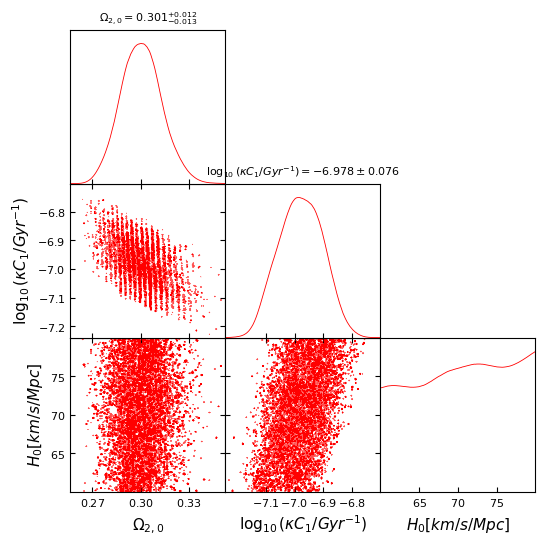

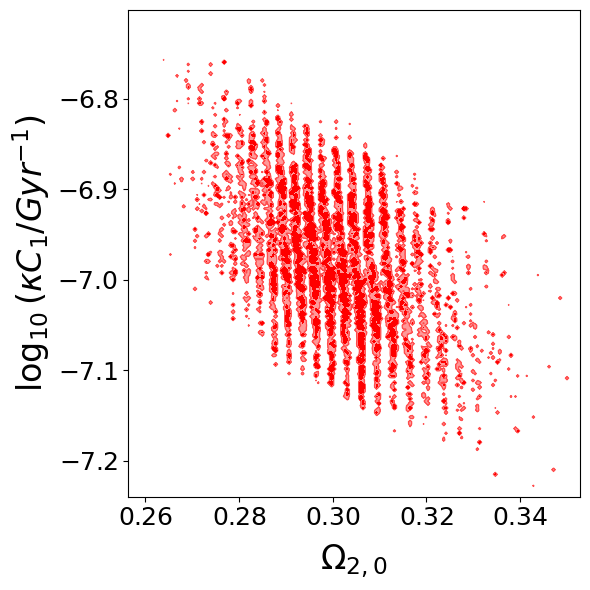

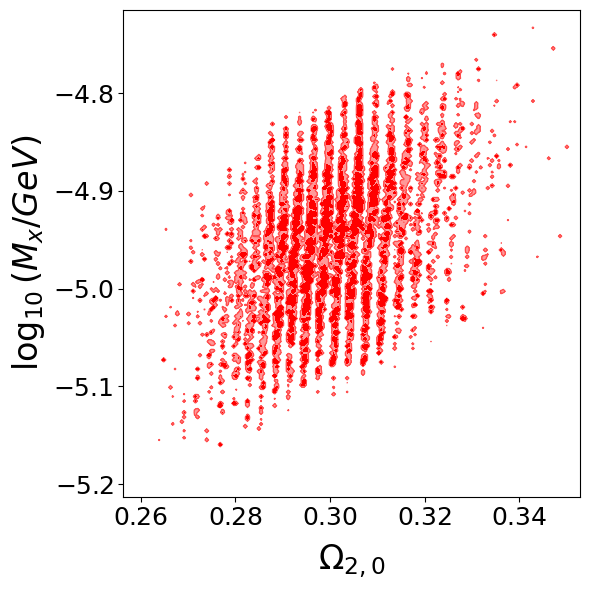

In [1]:
import multiprocessing as mp
from fixed import main

if __name__ == '__main__':
    mp.freeze_support()
    main()